In [28]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

In [29]:
#Define dataset directories
train_path = r"C:\Users\Asus\Desktop\ML\Deep-Learning\FER-2013\train"
test_path = r"C:\Users\Asus\Desktop\ML\Deep-Learning\FER-2013\test"

In [30]:
#define image transformations 
transform = transforms.Compose([transforms.Resize((48,48)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.5], std = [0.5])
                                ])


In [31]:
#load the dataset 
train_dataset = datasets.ImageFolder(root = train_path, transform = transform)
test_dataset = datasets.ImageFolder(root = test_path, transform = transform)


In [32]:
#Create dataloaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers= 4)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers= 4)

In [40]:
expression = train_dataset.classes
expression


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


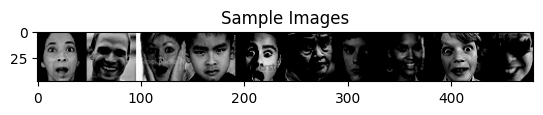

In [34]:
import matplotlib.pyplot as plt

# Get a batch of data
images, labels = next(iter(train_loader))
grid = torch.cat([images[i].squeeze(0) for i in range(10)], dim=2)  # Combine 10 images in a row
grid = grid.permute(1, 2, 0).numpy()  # Change shape to (height, width, channels) and convert to numpy array
plt.imshow(grid, cmap='gray')
plt.title("Sample Images")
plt.show()

In [35]:
class FacialExpressionCNN(nn.Module):
    def __init__(self, output_classes = 7):
        super(FacialExpressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride = 2)

        self.conv3 = nn.Conv2d(in_channels = 64, out_channels=128, kernel_size= 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride = 2)

        self.fc1 = nn.Linear(in_features=128 * 6 * 6, out_features=256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=256, out_features=output_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [36]:
#Instantiate model 
model = FacialExpressionCNN(output_classes = 7)
#Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [37]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train() #Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")



Epoch 1, Loss: 1.7122778577236397
Epoch 2, Loss: 1.5282538896281364
Epoch 3, Loss: 1.4593036578997207
Epoch 4, Loss: 1.4102988325407881
Epoch 5, Loss: 1.3665285313580775
Epoch 6, Loss: 1.3236418473295752
Epoch 7, Loss: 1.2908573065674915
Epoch 8, Loss: 1.2705395965108892
Epoch 9, Loss: 1.227368081399221
Epoch 10, Loss: 1.1987021057005713


In [38]:
#Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
    



Test Accuracy: 53.90%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to th

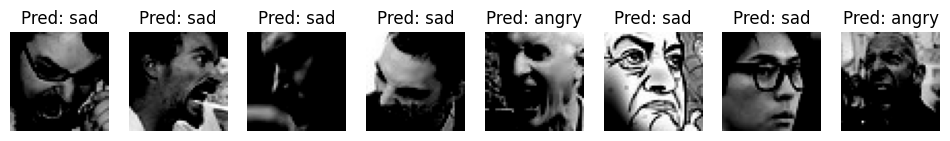

In [42]:
#Visualize Results 
inputs, labels = next(iter(test_loader))
inputs, labels = inputs[:8].to(device), labels[:8].to(device)
outputs = model(inputs)
_, pred = torch.max(outputs, 1)

fig, axes = plt.subplots(1, 8, figsize = (12,3))
for i in range(8):
    img = inputs[i].permute(1, 2, 0).cpu().numpy()  # Change shape to (height, width, channels) and convert to numpy array
    axes[i].imshow(img, cmap = "gray")
    axes[i].set_title(f"Pred: {expression[pred[i]]}")
    axes[i].axis("off")

plt.show()
